In [1]:
import calendar
import datetime
import string
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def get_months():
        result = []
        for n in range(1, 13):
            month_num = f"{n}"
            datetime_object = datetime.datetime.strptime(month_num, "%m")
            month_name = datetime_object.strftime("%b")
            result.append(month_name)
        return result

def build_board():
    # build the board
    row1 = get_months()[:6] + ['X']
    row2 = get_months()[6:] + ['X']
    day_pt1 = np.roll(list(calendar.day_abbr), 1)[:4]
    day_pt2 = np.roll(list(calendar.day_abbr), 1)[4:]
    day_pt2 = np.concatenate([['X'] * 4, day_pt2])

    cal = np.concatenate([row1, row2, np.array(range(1, 32)).astype(str), day_pt1, day_pt2])
    cal = cal.reshape(-1, 7)
    return cal

cal = build_board()

In [3]:
shapes_str = """
X X
XXX

 XX
XX

XXXX

XXX
X
X

XXX
XX

XX
 XXX

 X
 X
XXX

  X
XXX
X

X
XXXX

X
XXX
"""

def build_shapes():
    # build shapes
    shapes = []
    curr = []
    for l in shapes_str.split('\n'):
        if l.strip(' ') == "":
            if len(curr) == 0: continue
            width = max([len(c) for c in curr])
            curr = [c.ljust(width) for c in curr]
            curr = [list(c.replace('X', '1').replace(' ', '0')) for c in curr]
            shapes.append(np.array(curr).astype(int))
            curr = []
        else:
            curr.append(l)
    shapes = {letter: shape for letter, shape in zip(string.ascii_uppercase, shapes)}
    return shapes
shapes = build_shapes()

In [4]:
# define function for solving for the date

def calendar_solve(target_date: datetime, cal: np.array, shapes: Dict):
    day_of_week = list(calendar.day_abbr)[target_date.weekday()]
    month = target_date.strftime("%b")
    day = target_date.day
    ncal = np.isin(cal, ['X', day_of_week, month, day]).astype(int)
    unused = list(shapes.keys())
    ans = None
    
    def helper(ncal: np.array, unused: List[str], pos = (0, 0), used = []) -> List:
        nonlocal ans
        if ans:
            return ans
        
        if len(unused) == 0:
            # returns a list of (pos_x, pos_y, shapes key, rot)
            ans = used
            return ans
        
        if pos[0] >= ncal.shape[0] or pos[1] >= ncal.shape[1]:
            return None
        
        must_solve = ncal[pos[0], pos[1]] == 0
        for uu in unused:
            for n_rot in range(4):
                shape = np.rot90(shapes[uu], n_rot)
                if pos[0] + shape.shape[0] > ncal.shape[0] or pos[1] + shape.shape[1] > ncal.shape[1]:
                    continue
                ncal_view = ncal[pos[0]:pos[0] + shape.shape[0], pos[1]: pos[1] + shape.shape[1]]
                if (ncal_view + shape).max() > 1:
                    continue                    
                ncal_view += shape
                if must_solve and ncal[pos[0], pos[1]] == 0:
                    ncal_view -= shape
                    continue
                next_unused = [item for item in unused if item != uu]
                next_pos = divmod(pos[0] * cal.shape[1] + pos[1] + 1, cal.shape[1])
                next_used = [(pos[0], pos[1], uu, n_rot)]
                result = helper(ncal, next_unused, next_pos, used + next_used)
                if result:
                    return result
                else:
                    ncal_view -= shape
        if not must_solve:
            next_pos = divmod(pos[0] * cal.shape[1] + pos[1] + 1, cal.shape[1])
            helper(ncal, unused, next_pos, used)
        return None
           
    helper(ncal, unused)
    return ans
    
target_date = datetime.date.fromisoformat('2022-01-01')
solution = calendar_solve(target_date, cal, shapes)


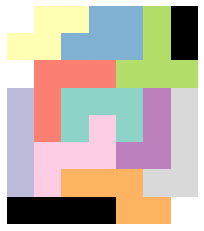

In [5]:
color_map = [
 [141, 211, 199],
 [255, 255, 179],
 [190, 186, 218],
 [251, 128, 114],
 [128, 177, 211],
 [253, 180, 98],
 [179, 222, 105],
 [252, 205, 229],
 [217, 217, 217],
 [188, 128, 189],
 [204, 235, 197],
 [255, 237, 111]]

color_map = {k: cm for k, cm in zip(shapes.keys(), color_map)}
color_map['X'] = [0, 0, 0]

def apply_calendar_solution(cal, solution, steps:Optional[int]=None):
    cal_solution = cal.copy()
    
    if steps:
        solution = solution[:steps]

    for m, n, key, rot in solution:
        rshape = np.rot90(shapes[key], rot)
        cal_view = cal_solution[m:m+rshape.shape[0],n:n+rshape.shape[1]]
        cal_view[:,:] = np.where(rshape == 1, key, cal_view)
    return cal_solution

def plot_solution(ax, cal, solution, steps:Optional[int]=None):
    cal_solution = apply_calendar_solution(cal, solution, steps)
    
    color_solution = []
    submap = {k: color_map[k] for k in list(color_map.keys())}
    for m in range(cal_solution.shape[0]):
        row = []
        for n in range(cal_solution.shape[1]):
            row.append(submap.get(cal_solution[m, n], [255, 255, 255]))
        color_solution.append(row)
    ax.imshow(color_solution, interpolation='nearest')

fig, ax = plt.subplots(1, 1)
plt.axis('off')
plot_solution(ax, cal, solution)
plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

year = 2022

with PdfPages(f'calendar_solutions_{year}.pdf') as pdf:
    for month in range(1,13):
        _, days = calendar.monthrange(2022, month)
        rows = int(np.ceil(days / 7))

        fig, axs = plt.subplots(rows, 7)
        fig.tight_layout()

        for day in range(1, rows * 7 + 1):
            m, n = divmod(day - 1, 7)
            axs[m][n].axis('off')
            
            if day > days:
                continue

            date_str = f'{year}-{str(month).zfill(2)}-{str(day).zfill(2)}'
            target_date = datetime.date.fromisoformat(date_str)
            cal = build_board()
            shapes = build_shapes()
            solution = calendar_solve(target_date, cal, shapes)

            print(target_date)
            axs[m][n].set_title(date_str, fontsize=4)
            if not solution:
                print('No solution')
                continue
            plot_solution(axs[m][n], cal, solution)
        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()
